## Load and Viz Models

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os
from torch.utils.data import DataLoader, TensorDataset

In [2]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<50
belgium_region=((map-belgium_color)**2).sum(-1)<10000

num_points_to_sample=10000 #10000

b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
belgium_coords=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]

In [3]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [4]:
model=torch.load('one_layer_64_nuerons_long.pt')

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.BaarleNet was not an allowed global by default. Please use `torch.serialization.add_safe_globals([BaarleNet])` or the `torch.serialization.safe_globals([BaarleNet])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
model

In [ ]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)

probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)
probe_logits=model(torch.tensor(probe).float())
probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))

ax.imshow(map.mean(2), cmap='gray')
ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
           extent=[0, 960, 960, 0],  # This maps to image coordinates
           alpha=0.7,
           cmap='viridis')

In [ ]:
model=torch.load('one_layer_10k_neurons_long.pt')

In [ ]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)

probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)
probe_logits=model(torch.tensor(probe).float())
probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))

ax.imshow(map.mean(2), cmap='gray')
ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
           extent=[0, 960, 960, 0],  # This maps to image coordinates
           alpha=0.7,
           cmap='viridis')

In [7]:
model=torch.load('one_layer_100k_neurons_long.pt', weights_only=False)

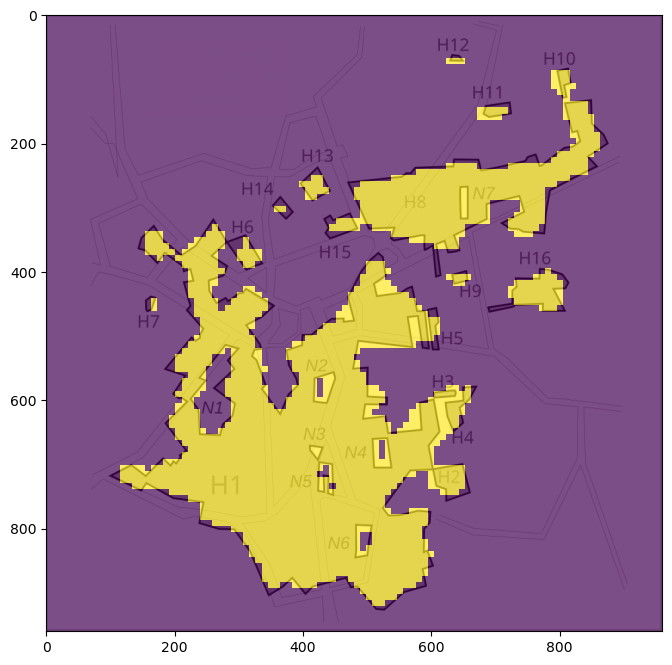

In [9]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)

probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)
probe_logits=model(torch.tensor(probe).float().to('cuda'))
probe_logits=probe_logits.cpu().detach().numpy().reshape(100,100,2)
probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))

ax.imshow(map.mean(2), cmap='gray')
ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
           extent=[0, 960, 960, 0],  # This maps to image coordinates
           alpha=0.7,
           cmap='viridis')